In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os
warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [2]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.5,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))


In [3]:
data_name = "future_brr_v4"
data_path = "../processed_data/"+data_name+"/"

k_arr = [10,20] # Absolute risk aversion for exponential risk measure
q_arr_ES = [0.01,0.05,0.1] # Quantile level for expected shortfall
q_arr_VaR = [0.01,0.05,0.1] # Quantile level for Value at Risk 

spot_name = "log return brr"
future_name = "log return future"

calibration_method = "MLE" # MM or MLE
ls = os.listdir(data_path+'train/')
ls = [l for l in ls if l.endswith('.csv')]

In [4]:
paras = pd.read_json("../results/"+ data_name +"/MLE/parameters.json")
likelihood = pd.read_json("../results/"+ data_name +"/MLE/likelihood.json")

In [6]:
best_h_results = []

for file in ls[0:2]:
    train = pd.read_csv(data_path+'train/'+file)
    spot   = train.loc[:,spot_name]
    future = train.loc[:,future_name]
    u = ECDF(spot)(spot)
    v = ECDF(future)(future)
    
    kde_brr = KDE(spot, "Gaussian")
    kde_btc = KDE(future, "Gaussian")
    
    # load paras
    for C_name in Copulae:
        p = paras.loc[C_name,file]
        if (C_name == 't_Copula') or (C_name == 't_Copula_Capped'):
            Copulae[C_name].__init__(p, kde_brr, kde_btc, nu_lowerbound=2)
        else: 
            Copulae[C_name].__init__(p, kde_brr, kde_btc)

        print(C_name, Copulae[C_name].paras)
        
    # Get Best h
    best_h = []
    for C_name in Copulae:
        best_h.append(optimize_h(Copulae[C_name], k_arr, q_arr_ES, q_arr_VaR))
    best_h = pd.DataFrame(best_h)
    best_h.columns = ['Variance'] + ['ERM k=%i'%k for k in k_arr] + ['ES q=%.2f'%q for q in q_arr_ES] + ['VaR q=%.2f'%q for q in q_arr_VaR]
    best_h.index = Copulae_names
    best_h_results.append(best_h)

Gaussian {'rho': 0.7617569150000001}
t_Copula {'rho': 0.790822855, 'nu': 2.0}
t_Copula_Capped {'rho': 0.8085356655, 'nu': 4.0}
Clayton {'theta': 1.9486336130000002}
Frank {'theta': 7.4086998991}
Gumbel {'theta': 2.2528967584}
Plackett {'theta': 24.2817455059}
Gauss Mix Indep {'rho': 0.9313929642000001, 'p': 0.732154528}
Optimization terminated successfully.
         Current function value: 0.001018
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.048239
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.064967
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.121053
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.074541
         Iterations: 14
         Function eval

Optimization terminated successfully.
         Current function value: 0.084289
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.060850
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.104556
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.047732
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.029771
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.001198
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.051906
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.031970
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000816
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.043675
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.058262
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.099214
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.067477
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.052405
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

In [7]:
best_h_results_pd = pd.concat(dict(zip(ls, best_h_results)), axis=1)

In [8]:
best_h_results_pd

6.csv                                                    \
                 Variance  ERM k=10  ERM k=20 ES q=0.01 ES q=0.05 ES q=0.10   
Gaussian         0.662793  0.639844  0.683789  0.763770  0.701855  0.644434   
t_Copula         0.705371  0.720410  0.714941  0.637793  0.732910  0.729297   
t_Copula_Capped  0.728711  0.724023  0.738477  0.715918  0.754590  0.730078   
Clayton          0.584473  0.515234  0.518359  0.552637  0.509570  0.510937   
Frank            0.552051  0.520801  0.546094  0.662598  0.543457  0.518066   
Gumbel           0.662988  0.733984  0.791992  0.989844  0.811914  0.752832   
Plackett         0.630078  0.609473  0.616406  0.672168  0.610547  0.600977   
Gauss Mix Indep  0.610547  0.613379  0.574121  0.528711  0.546680  0.605957   

                                                     7.csv            \
                VaR q=0.01 VaR q=0.05 VaR q=0.10  Variance  ERM k=10   
Gaussian          0.697070   0.549707   0.528320  0.622363  0.559375   
t_Copula          0.706934   0.800977   0.721484  0.645410  0.604199   
t_Copula_Capped   0.734570   0.685742   0.656250  0.667773  0.612500   
Clayton           0.453125   0.504102   0.544531  0.494141  0.427930   
Frank             0.567480   0.466211   0.476562  0.528223  0.466504   
Gumbel            0.911523   0.703711   0.612891  0.643848  0.646875   
Plackett          0.610937   0.539453   0.617480  0.587109  0.527051   
Gauss Mix Indep   0.586230   0.765039   0.710059  0.567676  0.509473   

                                                                               \
                 ERM k=20 ES q=0.01 ES q=0.05 ES q=0.10 VaR q=0.01 VaR q=0.05   
Gaussian         0.585156  0.607227  0.600195  0.570605   0.642187   0.533301   
t_Copula         0.576465  0.377148  0.578027  0.616406   0.569141   0.673340   
t_Copula_Capped  0.608008  0.524805  0.613574  0.623535   0.621973   0.653809   
Clayton          0.423535  0.386133  0.435449  0.431934   0.437695   0.472656   
Frank            0.482031  0.508398  0.486426  0.470703   0.510840   0.431543   
Gumbel           0.685449  0.732324  0.712598  0.669336   0.794727   0.636328   
Plackett         0.519922  0.482617  0.519434  0.525781   0.514844   0.524707   
Gauss Mix Indep  0.455469  0.289453  0.448340  0.515137   0.384766   0.634863   

                            
                VaR q=0.10  
Gaussian          0.464062  
t_Copula          0.693750  
t_Copula_Capped   0.637012  
Clayton           0.429687  
Frank             0.431348  
Gumbel            0.590039  
Plackett          0.574902  
Gauss Mix Indep   0.679297

In [112]:
HE_arr = []
for file in ls:
    test = pd.read_csv(data_path+'test/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    h_arr = best_h_results_pd.loc[:,file].Var
    HE=[]
    for h in h_arr:
        rh = spot-h*future
        HE.append(1-np.var(rh)/np.var(spot))
    HE_arr.append(HE)
    
HE_pd = pd.DataFrame(np.array(HE_arr).T)
HE_pd.index = Copulae_names
HE_pd.columns = ls
HE_pd.style.highlight_max(color = 'yellow', axis = 0)

,6.csv,7.csv,5.csv,4.csv,0.csv,1.csv,3.csv,2.csv,14.csv,10.csv,11.csv,13.csv,12.csv,9.csv,8.csv
Gaussian,0.73539,0.764602,0.369716,0.625449,0.682344,0.798679,0.582659,0.746519,0.718211,0.488692,0.25438,0.53639,0.504386,0.279748,0.683848
t_Copula,0.737508,0.774973,0.365457,0.619956,0.692168,0.820032,0.573553,0.747294,0.719157,0.499831,0.237511,0.520566,0.512342,0.257721,0.693704
t_Copula_Capped,0.736493,0.78511,0.360412,0.610169,0.698882,0.824506,0.568409,0.747085,0.719724,0.504229,0.228516,0.509164,0.514971,0.250243,0.701387
Clayton,0.718386,0.67892,0.374044,0.629036,0.646664,0.768052,0.591258,0.736757,0.703574,0.452401,0.277357,0.553256,0.480838,0.299118,0.629569
Frank,0.703523,0.708365,0.372066,0.622351,0.599004,0.696809,0.589063,0.714967,0.69593,0.455009,0.277047,0.553918,0.472586,0.298345,0.637475
Gumbel,0.73539,0.773856,0.371106,0.627754,0.661687,0.769456,0.588715,0.741274,0.717404,0.497597,0.242934,0.527268,0.510147,0.269078,0.691318
Plackett,0.729397,0.744925,0.373641,0.629128,0.630132,0.730396,0.591921,0.727929,0.715255,0.486303,0.256369,0.542659,0.503583,0.282835,0.673956
Gauss Mix Indep,0.724888,0.731134,0.373991,0.629225,0.669849,0.785434,0.587276,0.74539,0.699377,0.466388,0.270254,0.553567,0.482917,0.294399,0.654121


In [101]:
HE_arr = []
for file in ls:
    test = pd.read_csv(data_path+'train/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    h_arr = best_h_results_pd.loc[:,file].Var
    HE=[]
    for h in h_arr:
        rh = spot-h*future
        HE.append(1-np.var(rh)/np.var(spot))
    HE_arr.append(HE)
    
HE_pd = pd.DataFrame(np.array(HE_arr).T)
HE_pd.index = Copulae_names
HE_pd.columns = ls
HE_pd.style.highlight_max(color = 'yellow', axis = 0)

,6.csv,7.csv,5.csv,4.csv,0.csv,1.csv,3.csv,2.csv,14.csv,10.csv,11.csv,13.csv,12.csv,9.csv,8.csv
Gaussian,0.609317,0.543362,0.618168,0.606162,0.695925,0.620339,0.592095,0.605274,0.632119,0.580513,0.612131,0.652365,0.608998,0.559949,0.542527
t_Copula,0.610419,0.543174,0.619352,0.607824,0.698305,0.623877,0.592713,0.60786,0.633471,0.583753,0.613982,0.656349,0.613614,0.563199,0.544687
t_Copula_Capped,0.609194,0.541575,0.618904,0.607438,0.699409,0.624289,0.592244,0.608053,0.635142,0.583849,0.613312,0.657005,0.614203,0.562646,0.545012
Clayton,0.596211,0.517872,0.606449,0.596417,0.681418,0.611624,0.585343,0.594307,0.616523,0.556284,0.591713,0.63213,0.588186,0.531611,0.516759
Frank,0.584294,0.530221,0.594504,0.580034,0.652262,0.580071,0.568734,0.574071,0.60909,0.558426,0.592446,0.62214,0.579896,0.536348,0.521327
Gumbel,0.609317,0.543257,0.617114,0.604065,0.68849,0.612102,0.589178,0.598939,0.631094,0.583396,0.613911,0.655239,0.612632,0.562701,0.544306
Plackett,0.604852,0.540929,0.612149,0.597132,0.672334,0.596556,0.581961,0.585854,0.628589,0.579433,0.611524,0.648846,0.608412,0.558496,0.539168
Gauss Mix Indep,0.601347,0.537653,0.609743,0.59889,0.691778,0.617031,0.590263,0.603683,0.612417,0.567201,0.602894,0.63033,0.59022,0.547168,0.530255


In [133]:
HE_pd.std(axis=1)

Gaussian           0.118944
t_Copula           0.138229
t_Copula_Capped    0.142934
Clayton            0.084204
Frank              0.088050
Gumbel             0.149854
Plackett           0.103514
Gauss Mix Indep    0.109823
dtype: float64

In [134]:
HE_pd.mean(axis=1)

Gaussian           0.325075
t_Copula           0.324730
t_Copula_Capped    0.322945
Clayton            0.305456
Frank              0.310020
Gumbel             0.320931
Plackett           0.323721
Gauss Mix Indep    0.319700
dtype: float64

In [135]:
HE_pd.mean(axis=1)/HE_pd.std(axis=1)

Gaussian           2.733012
t_Copula           2.349215
t_Copula_Capped    2.259404
Clayton            3.627572
Frank              3.520954
Gumbel             2.141620
Plackett           3.127302
Gauss Mix Indep    2.911046
dtype: float64

In [110]:
best_h_results_pd.droplevel(0,axis=1).loc[:,'Var']

,Var,Var,Var,Var,Var,Var,Var,Var,Var,Var,Var,Var,Var,Var,Var
Gaussian,0.735449,0.671777,0.608301,0.642285,0.615820,0.672461,0.681152,0.681543,0.670020,0.661426,0.670996,0.670312,0.638184,0.601953,0.605762
t_Copula,0.756543,0.706152,0.647461,0.683789,0.657227,0.710937,0.693555,0.714941,0.700391,0.688379,0.697559,0.712402,0.659863,0.628711,0.661914
t_Copula_Capped,0.771680,0.713770,0.665918,0.702637,0.676855,0.733105,0.720020,0.720801,0.714160,0.720703,0.721387,0.735059,0.683496,0.653906,0.677344
Clayton,0.666895,0.627051,0.515332,0.550293,0.538672,0.591309,0.607227,0.621680,0.615820,0.603223,0.600586,0.594336,0.505664,0.498926,0.500488
Frank,0.588770,0.537207,0.520996,0.552441,0.517969,0.565039,0.584375,0.558887,0.553809,0.549707,0.561328,0.556348,0.545020,0.511328,0.512598
Gumbel,0.694434,0.629004,0.638867,0.671484,0.643945,0.696094,0.673437,0.641992,0.639453,0.643555,0.659570,0.670312,0.657422,0.621777,0.635547
Plackett,0.638379,0.577539,0.600879,0.636621,0.612402,0.652344,0.657812,0.591992,0.599805,0.606250,0.626172,0.634082,0.601855,0.578906,0.595703
Gauss Mix Indep,0.710156,0.651855,0.547168,0.588379,0.544238,0.586230,0.594141,0.669238,0.648340,0.614160,0.614453,0.615723,0.579102,0.539648,0.545117


In [12]:
best_h_results_pd.loc[:,file].columns

Index(['Var', 'ERM k=10', 'ERM k=20', 'ES q=0.01', 'ES q=0.05', 'ES q=0.10'], dtype='object')

In [132]:
HE_arr = []
for file in ls:
    _data = pd.read_csv(data_path+'test/'+file)
    spot   = _data.loc[:,spot_name]
    future = _data.loc[:,future_name]
    h_arr = best_h_results_pd.loc[:,file].loc[:,'ERM k=10']
    HE=[]
    for h in h_arr:
        rh = spot-h*future
        HE.append(1-ERM_estimate_trapezoidal(10,rh)/ERM_estimate_trapezoidal(10,spot))
    HE_arr.append(HE)
    
HE_pd = pd.DataFrame(np.array(HE_arr).T)
HE_pd.index = Copulae_names
HE_pd.columns = ls
HE_pd.style.highlight_max(color = 'yellow', axis = 0)

,6.csv,7.csv,5.csv,4.csv,0.csv,1.csv,3.csv,2.csv,14.csv,10.csv,11.csv,13.csv,12.csv,9.csv,8.csv
Gaussian,0.511952,0.508737,0.258986,0.144674,0.384075,0.401469,0.37031,0.20852,0.335991,0.336948,0.111707,0.303221,0.265245,0.282979,0.451316
t_Copula,0.524993,0.546422,0.268476,0.0913489,0.400992,0.427667,0.365299,0.152926,0.335557,0.345816,0.111703,0.29386,0.275546,0.264033,0.466315
t_Copula_Capped,0.524334,0.551903,0.269493,0.0606329,0.400707,0.427807,0.364328,0.15072,0.335338,0.346092,0.111691,0.293711,0.275454,0.263937,0.468034
Clayton,0.450888,0.391843,0.225556,0.230328,0.339243,0.339983,0.369431,0.294981,0.332151,0.31235,0.103139,0.295684,0.238869,0.279783,0.377609
Frank,0.453812,0.426913,0.226662,0.223466,0.327549,0.32883,0.368889,0.295225,0.335519,0.320509,0.108056,0.297244,0.243018,0.290596,0.404008
Gumbel,0.52028,0.579797,0.271433,0.0379958,0.398031,0.426681,0.362502,0.150604,0.326822,0.350562,0.109908,0.28091,0.27828,0.247523,0.472636
Plackett,0.500951,0.47959,0.247492,0.189476,0.350421,0.352146,0.373,0.282449,0.336268,0.335997,0.1117,0.305187,0.265036,0.283425,0.442676
Gauss Mix Indep,0.503707,0.465642,0.250389,0.168711,0.383788,0.401567,0.370598,0.203451,0.336374,0.328608,0.111177,0.305554,0.254108,0.291815,0.420014


In [14]:
HE_pd.mean(axis=1)

Gaussian           0.376300
t_Copula           0.382219
t_Copula_Capped    0.382314
Clayton            0.341701
Frank              0.346794
Gumbel             0.381300
Plackett           0.366433
Gauss Mix Indep    0.370119
dtype: float64

[]

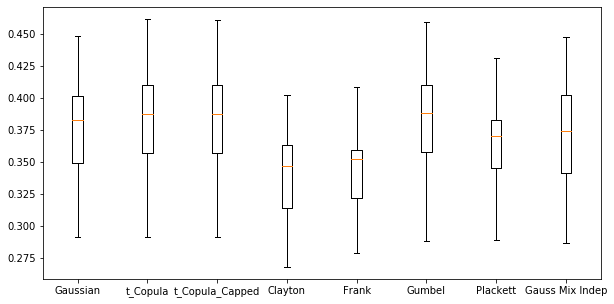

In [15]:
plt.figure(figsize=(10,5))
for i in range(len(Copulae_names)):
    plt.boxplot(HE_pd.iloc[i,:], positions=[i])
plt.xticks(range(len(Copulae_names)), Copulae_names)
plt.plot()



In [16]:
best_h_results_pd.loc[:,'0.csv'].loc[:,'ES q=0.10']

Gaussian           0.700781
t_Copula           0.765723
t_Copula_Capped    0.761621
Clayton            0.557129
Frank              0.549805
Gumbel             0.764844
Plackett           0.595117
Gauss Mix Indep    0.705469
Name: ES q=0.10, dtype: float64

In [17]:
paras.loc[:,'0.csv']

Clayton                                   {'theta': 2.3547013519}
Frank                                     {'theta': 8.1265123689}
Gauss Mix Indep    {'rho': 0.8832231771, 'p': 0.8766739264000001}
Gaussian                                    {'rho': 0.8100593559}
Gumbel                                     {'theta': 2.386565732}
Plackett                                 {'theta': 23.7022929155}
t_Copula                {'rho': 0.8138681204, 'nu': 2.4205629169}
t_Copula_Capped                  {'rho': 0.8289720538, 'nu': 4.0}
Name: 0.csv, dtype: object

In [18]:
likelihood.loc[:,'0.csv']

Clayton            0.493552
Frank              0.493054
Gauss Mix Indep    0.561295
Gaussian           0.526979
Gumbel             0.503184
Plackett           0.543301
t_Copula           0.576531
t_Copula_Capped    0.574070
Name: 0.csv, dtype: float64

In [94]:
HE_arr = []
for file in ls:
    _data = pd.read_csv(data_path+'train/'+file)
    spot   = _data.loc[:,spot_name]
    future = _data.loc[:,future_name]
    h_arr = best_h_results_pd.loc[:,file].loc[:,'ES q=0.05']
    HE=[]
    for h in h_arr:
        rh = spot-h*future
        HE.append(1-ES(0.05,rh)/ES(0.05,spot))
    HE_arr.append(HE)
    
HE_pd = pd.DataFrame(np.array(HE_arr).T)
HE_pd.index = Copulae_names
HE_pd.columns = ls
HE_pd.style.highlight_max(color = 'yellow', axis = 0)

,6.csv,7.csv,5.csv,4.csv,0.csv,1.csv,3.csv,2.csv,14.csv,10.csv,11.csv,13.csv,12.csv,9.csv,8.csv
Gaussian,0.396002,0.297471,0.422602,0.423181,0.510425,0.441653,0.422545,0.418018,0.404237,0.342984,0.376875,0.445942,0.406816,0.323981,0.323992
t_Copula,0.399501,0.297255,0.423582,0.423057,0.520374,0.447706,0.422287,0.425278,0.4079,0.341901,0.378372,0.446679,0.407172,0.323995,0.320685
t_Copula_Capped,0.398616,0.296763,0.42424,0.421245,0.520528,0.448113,0.421677,0.425847,0.404819,0.342929,0.37332,0.438974,0.402772,0.32199,0.324189
Clayton,0.348799,0.270677,0.375791,0.381182,0.442776,0.389505,0.379537,0.368832,0.379882,0.298924,0.340515,0.418181,0.358023,0.287916,0.288124
Frank,0.363469,0.283997,0.391482,0.397332,0.438921,0.389136,0.394251,0.376668,0.404931,0.323151,0.367641,0.42834,0.380499,0.308877,0.310827
Gumbel,0.385443,0.277824,0.412268,0.407395,0.521996,0.452559,0.411835,0.428929,0.374144,0.331687,0.345317,0.400482,0.378806,0.304045,0.303467
Plackett,0.380274,0.291715,0.40479,0.405054,0.461454,0.400255,0.401721,0.384525,0.407336,0.334833,0.377946,0.442864,0.399705,0.319949,0.317731
Gauss Mix Indep,0.364125,0.274847,0.391784,0.404477,0.506869,0.438112,0.418056,0.416766,0.368642,0.297276,0.344451,0.405886,0.344002,0.286544,0.284089


In [95]:
HE_pd.mean(axis=1)

Gaussian           0.397115
t_Copula           0.399050
t_Copula_Capped    0.397735
Clayton            0.355244
Frank              0.370635
Gumbel             0.382413
Plackett           0.382010
Gauss Mix Indep    0.369728
dtype: float64

[]

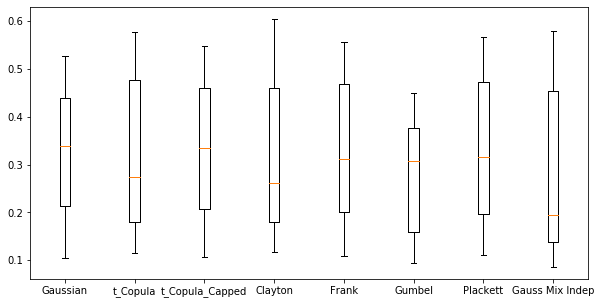

In [79]:
plt.figure(figsize=(10,5))
for i in range(len(Copulae_names)):
    plt.boxplot(HE_pd.iloc[i,:], positions=[i])
plt.xticks(range(len(Copulae_names)), Copulae_names)
plt.plot()

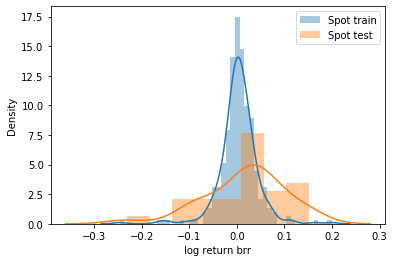

In [80]:
file='0.csv'
_data = pd.read_csv(data_path+'train/'+file)
spot_train   = _data.loc[:,spot_name]
future_train = _data.loc[:,future_name]

_data = pd.read_csv(data_path+'test/'+file)
spot_test   = _data.loc[:,spot_name]
future_test = _data.loc[:,future_name]

# plt.figure(figsize=(5,5))
# plt.scatter(spot, future)

sns.distplot(spot_train, label="Spot train")
sns.distplot(spot_test, label="Spot test")
plt.legend()

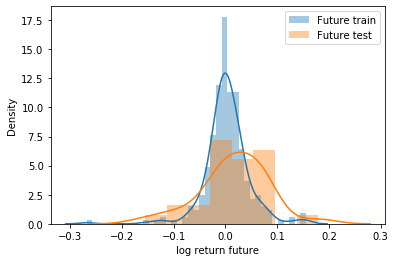

In [81]:
sns.distplot(future_train, label="Future train")
sns.distplot(future_test, label="Future test")
plt.legend()

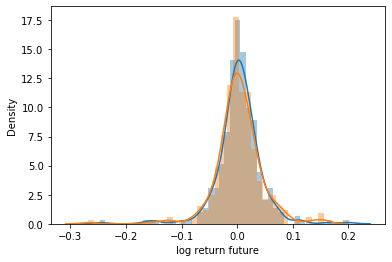

In [82]:
sns.distplot(spot_train)
sns.distplot(future_train)

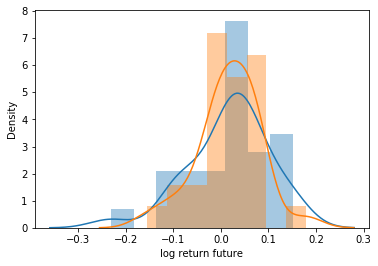

In [83]:
sns.distplot(spot_test)
sns.distplot(future_test)

In [84]:
kde_spot_train = KDE(spot_train, 'Gaussian')
kde_spot_test = KDE(spot_test, 'Gaussian')

def KL(P, Q, _max, _min):
    # compute D(P||Q) for given distribution
    fn = lambda x: P.pdf(x)*np.log(P.pdf(x)/Q.pdf(x))
    return scipy.integrate.quad(fn, _min, _max)

def KL2(P, Q): # for KDEs
    # compute D(P||Q) for given distribution
    X = list(P.data) + list(Q.data)
    fn = lambda x: P.cdf(x)*np.log(P.cdf(x)/Q.cdf(x))
    S = np.array([fn(x) for x in X])
    S = S[np.isfinite(S)]
    return np.sum(S)

print("D(Spot train||Spot test)=",KL2(kde_spot_train, kde_spot_test))

D(Spot train||Spot test)= 55.8561307613002


In [85]:
P = KDE(spot_train, 'Gaussian')
Q = KDE(spot_test, 'Gaussian')

X = np.array(list(P.data) + list(Q.data))


fn = lambda x: P.cdf(x)*np.log(P.cdf(x)/Q.cdf(x))
S = np.array([fn(x) for x in X])

X[np.isnan(S)]

array([], dtype=float64)

In [86]:
kde_future_train = KDE(future_train, 'Gaussian')
kde_future_test = KDE(future_test, 'Gaussian')

print("D(Future train||Future test)=", KL2(kde_future_train, kde_future_test))

D(Future train||Future test)= 43.485249254946346


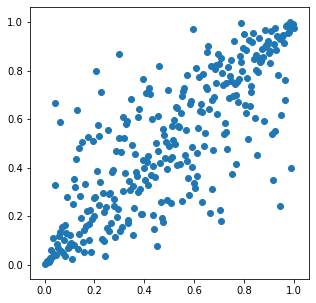

In [87]:
u_train = ECDF(spot_train)(spot_train)
v_train = ECDF(future_train)(future_train)
plt.figure(figsize=(5,5))
plt.scatter(u_train, v_train)

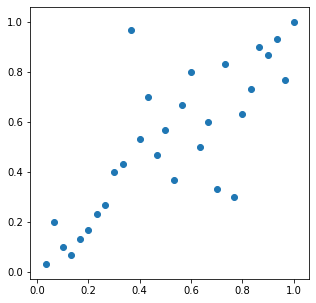

In [88]:
u_test = ECDF(spot_test)(spot_test)
v_test = ECDF(future_test)(future_test)
plt.figure(figsize=(5,5))
plt.scatter(u_test, v_test)

In [89]:
best_h_results_pd.loc[:,file].loc[:,'ES q=0.10']

Gaussian           0.700781
t_Copula           0.765723
t_Copula_Capped    0.761621
Clayton            0.557129
Frank              0.549805
Gumbel             0.764844
Plackett           0.595117
Gauss Mix Indep    0.705469
Name: ES q=0.10, dtype: float64

In [34]:
paras.loc[:,file]

Clayton                                   {'theta': 2.3547013519}
Frank                                     {'theta': 8.1265123689}
Gauss Mix Indep    {'rho': 0.8832231771, 'p': 0.8766739264000001}
Gaussian                                    {'rho': 0.8100593559}
Gumbel                                     {'theta': 2.386565732}
Plackett                                 {'theta': 23.7022929155}
t_Copula                {'rho': 0.8138681204, 'nu': 2.4205629169}
t_Copula_Capped                  {'rho': 0.8289720538, 'nu': 4.0}
Name: 0.csv, dtype: object

In [35]:
likelihood.loc[:,file]

Clayton            0.493552
Frank              0.493054
Gauss Mix Indep    0.561295
Gaussian           0.526979
Gumbel             0.503184
Plackett           0.543301
t_Copula           0.576531
t_Copula_Capped    0.574070
Name: 0.csv, dtype: float64